# Model Inspection aka Interpretable Machine Learning

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn import tree
from IPython.display import Image  
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import is_classifier, is_regressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn import tree
from IPython.display import Image  
from numpy import linalg
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


def kaggle_score(y_true,y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred));
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [1]:
!pip install shap
!pip install xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 20.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.2 MB/s eta 0:00:0000:0100:01


In [2]:
import shap
import xgboost

/home/codespace/.python/current/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/codespace/.python/current/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

## Data sets

In [5]:
adult = pd.read_csv("datasets/adult/adult.csv", delimiter=",", skipinitialspace=True)
print("Adult Shape:", adult.shape)
adult.head(5)

Adult Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
adult_small = adult.sample(1000)
print(adult_small.shape)

(1000, 15)


In [7]:
dataset = adult_small
#y = y.replace(["yes","no"],[1,0])
#X = pd.get_dummies(X)
oe = OrdinalEncoder()
data = oe.fit_transform(dataset)
encoded = pd.DataFrame(data = data, columns = dataset.columns)
X = encoded.loc[:,'age':'native-country']
y = encoded.loc[:,'y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = DecisionTreeClassifier(max_depth=5)
#clf = RandomForestClassifier()
model.fit(X_train, y_train);

y_pred1 = model.predict(X_test)  

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89        74
         1.0       0.74      0.54      0.62        26

    accuracy                           0.83       100
   macro avg       0.79      0.74      0.76       100
weighted avg       0.82      0.83      0.82       100



In [5]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
#bank = pd.read_csv("bank-full.csv", delimiter = ";")
# print first 5 examples
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [309]:
X = bank.loc[:,'age':'poutcome']
X["random_num"] = np.random.rand(X.shape[0])
X.drop(columns=['duration'], inplace=True)

y = bank.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
model = RandomForestClassifier()
model.fit(X_train, y_train);

y_pred1 = model.predict(X_test)  

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3980
           1       0.68      0.21      0.33       542

    accuracy                           0.89      4522
   macro avg       0.79      0.60      0.63      4522
weighted avg       0.88      0.89      0.87      4522



## Tree Models

### Feature Importances

Let us first look at feature importances in the bank marketing dataset



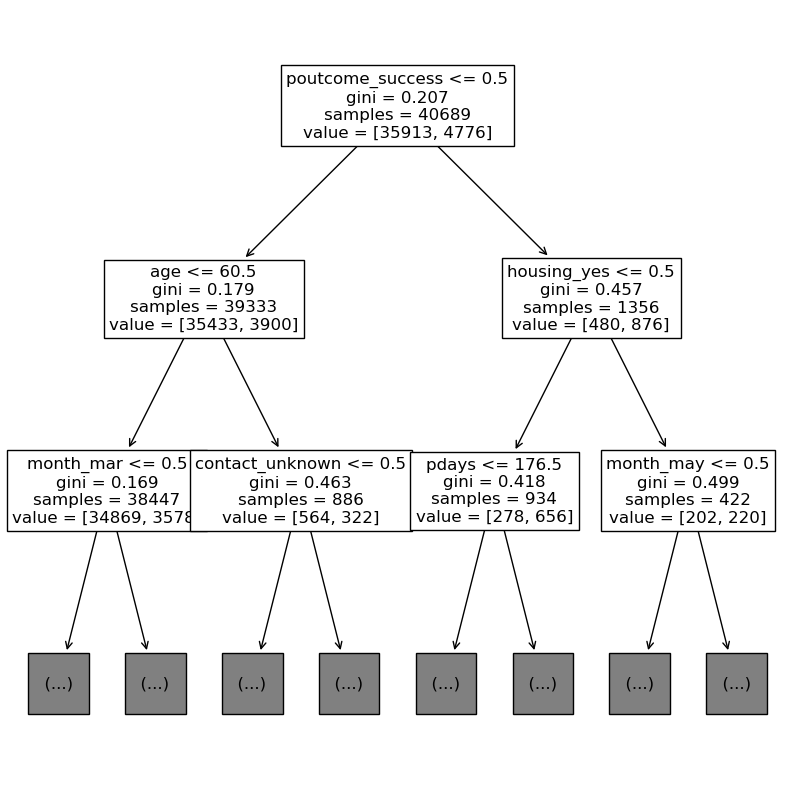

In [7]:
plt.figure(figsize=(10,10));
tree.plot_tree(model, feature_names=X.columns,max_depth=2, fontsize=12);

### Feature importance scores

Total reduction in impurity brought by the feature (for categorical classes) and total reduction in variance brought by the feature (for numerical classes). Impurity-based feature importances can be misleading for high cardinality features.

In [9]:
X.columns

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'random_num',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [310]:
imps = model.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals}
pd.DataFrame(d)

,features,values
0,balance,0.134336
1,random_num,0.132220
2,age,0.119473
3,day,0.102082
4,campaign,0.051573
5,poutcome_success,0.050887
6,pdays,0.043839
7,previous,0.021934
8,education_secondary,0.014218
9,housing_yes,0.012959


### sklearn tree structure

The entire binary tree structure is represented as a number of parallel arrays. The i-th element of each array holds information about the node i. Node 0 is the tree’s root. Nunbers are assigned in a depth-first order.

Some of these are:

- children_left[i]: id of the left child of node i or -1 if leaf node

- children_right[i]: id of the right child of node i or -1 if leaf node

- feature[i]: feature used for splitting node i

- threshold[i]: threshold value at node i

- n_node_samples[i]: the number of training samples reaching node i

- impurity[i]: the impurity at node i

For more information:
[sklearn tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)

### Feature importances from scratch

In [9]:
def MyFeatureImportance(tree, idx, imps, normalized = True):
    """
    :tree: Decision tree built
    :idx: Index of the root of the subtree that the importances will be calculated.
    :imps: feature importances, should be initialized to all zeros 
    :return: imps
    """
    if tree.children_left[idx] > -1:
        imps[tree.feature[idx]]+=(tree.n_node_samples[idx]*tree.impurity[idx] 
        - tree.n_node_samples[tree.children_left[idx]]*tree.impurity[tree.children_left[idx]]
        - tree.n_node_samples[tree.children_right[idx]]*tree.impurity[tree.children_right[idx]])

        MyFeatureImportance(tree, tree.children_left[idx], imps, normalized)
        MyFeatureImportance(tree, tree.children_right[idx], imps, normalized)
    
    if normalized:
        return imps/np.sum(imps)
    else:
        return imps

Now, let us check my_feature_importance finds the same importance values as sklearn

In [10]:
my_imps = np.zeros(model.n_features_in_)
my_imps = MyFeatureImportance(model.tree_,0, my_imps, normalized=True)
my_sorted_idx = np.argsort(my_imps)[::-1]
my_sorted_vals = np.sort(my_imps)[::-1]

d = {"features":X.columns[my_sorted_idx], "values":my_sorted_vals, "sklearn features":X.columns[sorted_idx], "sklearn values":sorted_vals}
pd.DataFrame(d)

,features,values,sklearn features,sklearn values
0,poutcome_success,0.625255,poutcome_success,0.625255
1,age,0.106646,age,0.106646
2,month_mar,0.076586,month_mar,0.076586
3,month_jun,0.065214,month_jun,0.065214
4,contact_unknown,0.064779,contact_unknown,0.064779
5,housing_yes,0.014680,housing_yes,0.014680
6,pdays,0.008205,pdays,0.008205
7,campaign,0.005863,campaign,0.005863
8,month_apr,0.005843,month_apr,0.005843
9,day,0.005081,day,0.005081


Let us now look at house price prediction dataset

In [11]:
# Run Regression Tree with top correlated 10 attributes with SalePrice

train = pd.read_csv("../datasets/house_prices/train.csv")
#train = pd.read_csv("train.csv")
#test = pd.read_csv("../datasets/house_prices/test.csv")

cors = train.corr(); 
top10 = cors.loc[:, "SalePrice"].sort_values(ascending = False).head(11)
top10 = top10.index.values.tolist()
top10.pop(0)

X = train.loc[:,top10]
y = train.loc[:,'SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    #X_train = X_train.fillna(X_train.mean())
    #X_test = X_test.fillna(X_test.mean())
regr = DecisionTreeRegressor()
model = regr.fit(X_train, y_train)
test_predictions = model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, test_predictions))



Test MAE: 23204.578767123287


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [12]:
imps = regr.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]



my_imps = np.zeros(regr.n_features_in_)
my_imps = MyFeatureImportance(regr.tree_,0, my_imps)
my_sorted_idx = np.argsort(my_imps)[::-1]
my_sorted_vals = np.sort(my_imps)[::-1]

d = {"features":X.columns[my_sorted_idx], "values":my_sorted_vals, "sklearn features":X.columns[sorted_idx], "sklearn values":sorted_vals}
pd.DataFrame(d)

,features,values,sklearn features,sklearn values
0,OverallQual,0.645492,OverallQual,0.645492
1,GrLivArea,0.122408,GrLivArea,0.122408
2,TotalBsmtSF,0.058700,TotalBsmtSF,0.058700
3,YearRemodAdd,0.044361,YearRemodAdd,0.044361
4,YearBuilt,0.029778,YearBuilt,0.029778
5,1stFlrSF,0.029736,1stFlrSF,0.029736
6,GarageCars,0.024715,GarageCars,0.024715
7,GarageArea,0.022997,GarageArea,0.022997
8,FullBath,0.014095,FullBath,0.014095
9,TotRmsAbvGrd,0.007718,TotRmsAbvGrd,0.007718


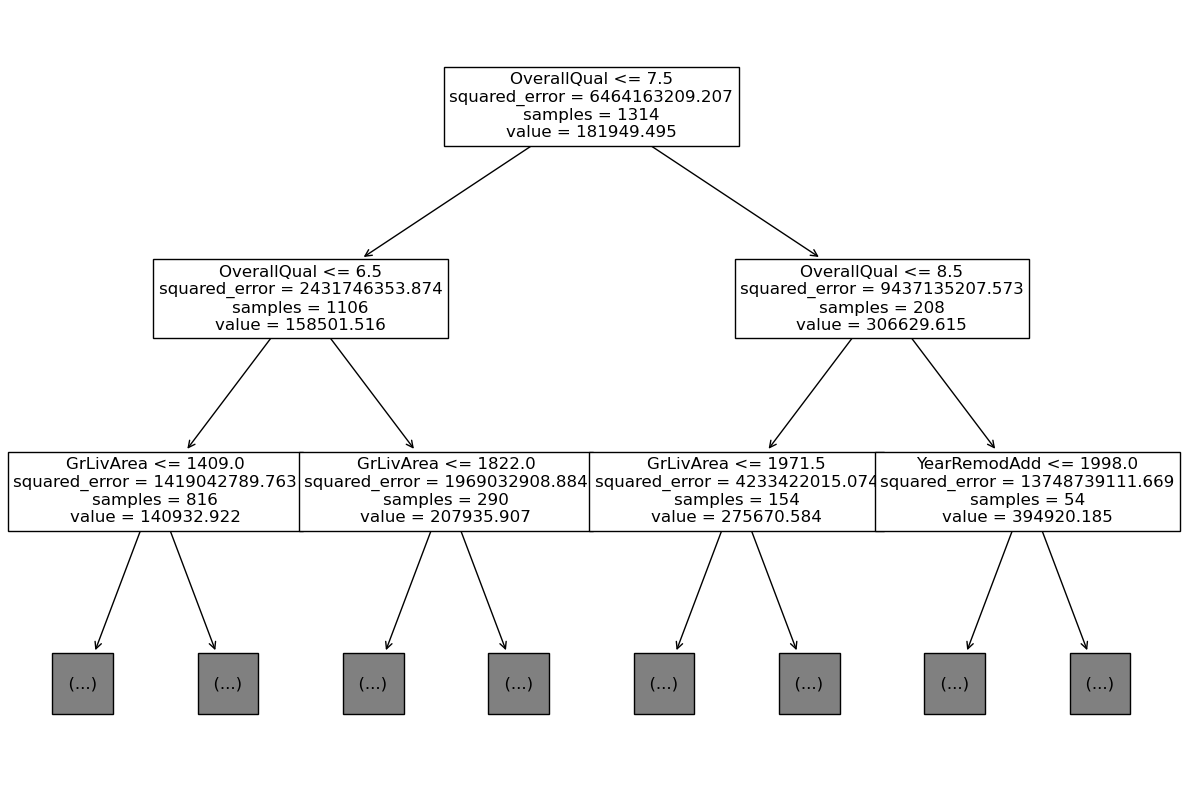

In [13]:
plt.figure(figsize=(15,10));
tree.plot_tree(regr, feature_names=X.columns,max_depth=2, fontsize=12);

### Discussion

- Feature importance scores are computed on the model which is fitted on the training set, therefore if a model overfits than the scores can be misleading. You can try to add a random feature to see this result.
- It is better to evaluate the importance of a feature on the test set. Permutation importance can help at this point.
- It is important not to forget that these scores only show the importance of a feature relative to a model. In other words how much a model relies on a feature. A feature which might not be used by a model does not mean that that feature is unimportant in general. This might happen, for example, when there are two important but correlated features. A decision tree will choose one of them and will not use the other one. This does not mean that the unused feature is not important in general.
- Permutation feature importance requires the true labels in addition to the model.
- Correlated features might create problems. Suppose that feature A is very important, if you add a correlated feature B, and then train a random forest, then some of the trees will use feature A and some of the trees will use feature B. As a result, the importance of these features will decrease.

### Permutation Importance

Permutation importance of a feature in the decrease in model score when the values of that feature are randomly shuffled.

In [14]:
X = bank_balanced.loc[:,'age':'poutcome']
X["random_num"] = np.random.rand(X.shape[0])
X.drop(columns=['duration'], inplace=True)

y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf = RandomForestClassifier()
clf.fit(X_train, y_train);

y_pred1 = clf.predict(X_test)  

print(classification_report(y_test,y_pred1))

NameError: name 'bank_balanced' is not defined

In [15]:
X.shape

(1460, 10)

In [16]:
perm_test = permutation_importance(clf, X_test, y_test)
perm_train = permutation_importance(clf, X_train, y_train)

NameError: name 'clf' is not defined

In [17]:
imps = clf.feature_importances_
sorted_idx = np.argsort(imps)[::-1]
sorted_vals = np.sort(imps)[::-1]

perm_imps_test = perm_test['importances_mean']
perm_sorted_idx_test = np.argsort(perm_imps_test)[::-1]
perm_sorted_vals_test = np.sort(perm_imps_test)[::-1]

perm_imps_train = perm_train['importances_mean']
perm_sorted_idx_train = np.argsort(perm_imps_train)[::-1]
perm_sorted_vals_train = np.sort(perm_imps_train)[::-1]

d = {"Perm. features Test":X.columns[perm_sorted_idx_test], "Perm. Imp. Test":perm_sorted_vals_test,"Perm. features Train":X.columns[perm_sorted_idx_train], "Perm. Imp.Train":perm_sorted_vals_train, "Feature Imp. features":X.columns[sorted_idx], "Feature Imp.":sorted_vals}
pd.DataFrame(d)

NameError: name 'clf' is not defined

### Partial Dependency Plots (PDPs)

Sometimes we might want to understand the effect of a single feature on the output variable. In particular how does the output variable change as the input variable changes (increases and decreases)?

If we have the true function relating x to y then we can fulfill this aim. The function can be simple, complex or multivariate.

If $y = x$, then it is easy to describe the behavior of y as x changes: there is a positive linear relationship. What about $y = x + x^2 + 20x^3 - x^4$? 

Well, the derivative of y with respect to x is not the same for all values of x which means that the behavior of y as x changes differs depending on the value of x. 

When we have two variables we can still use visualization (contour or mesh plots) in order to understand the effect of the change in the variables on the output variable. However, for higher dimensional functions visualization is not possible. One possible solution is called Partial Dependendence Plots (PDPs) proposed by Friedman (2001) in his seminal gradient boosting machines paper. The reason was that, gradient boosting, unlike single decision trees, create models consisting of many trees (sometimes hundreds of trees). And it is almost impossible to understand the function represented by these trees. 

Suupose that we have $n$ variables $X = {x_1, x_2, ..., x_n}$ and $X_S = {x_1, x_2, ..., x_l}$ and $X_C = X  \backslash  X_S$. Then the partial dependence of the response $f$ at a point $X_S$ is given by:
$$
pd(X_S) = E_{X_C}[f(X_S, X_C)] = \int f(X_S,X_C)dP(X_C)
$$

We can estimate the function as follows:

$$
pd(X_S) = \frac{1}{m}\sum_{i=1}^mf(X_S,X_C^{(i)})
$$


In [18]:
def foo(x):
    return x + x**2 + 20*x**3 - x**4

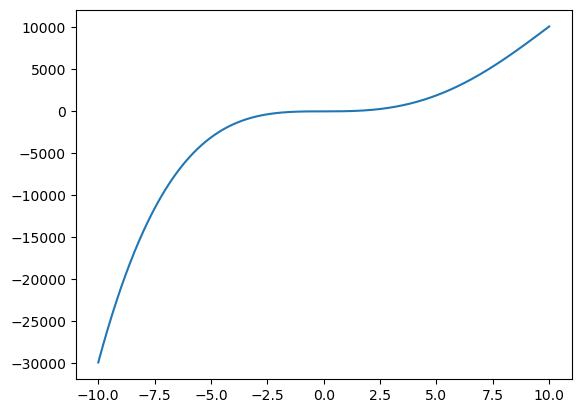

In [19]:
x = np.linspace(-10, 10, 1000)
y = foo(x)
plt.plot(x, y);

How can a similar plot can be drawn for the following multivariate function? That is, how can we plot how y varies as we vary x?

In [20]:
def foo2(x,y,z):
    return x + y**2 + 20*x**3 - y**4

### Regression Problem - Bike Sharing Dataset

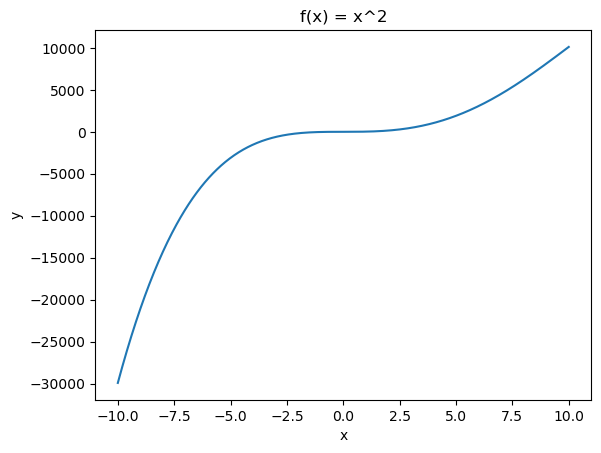

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function you want to plot
def f(x):
    return x**2

# Generate some x values to plot over
x = np.linspace(-10, 10, 1000)

# Evaluate the function for each x value
y = foo(x)

# Plot the function
plt.plot(x, y)

# Add labels and a title
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x) = x^2')

# Show the plot
plt.show()


In [22]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target


In [23]:
X.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0


In [24]:
y.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [25]:
X["weather"].value_counts()

clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: weather, dtype: int64

In [26]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

In [27]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [28]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)


In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

In [30]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features, random_state=0
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.719s
Test R2 score: 0.64


Computing partial dependence plots...
done in 7.399s


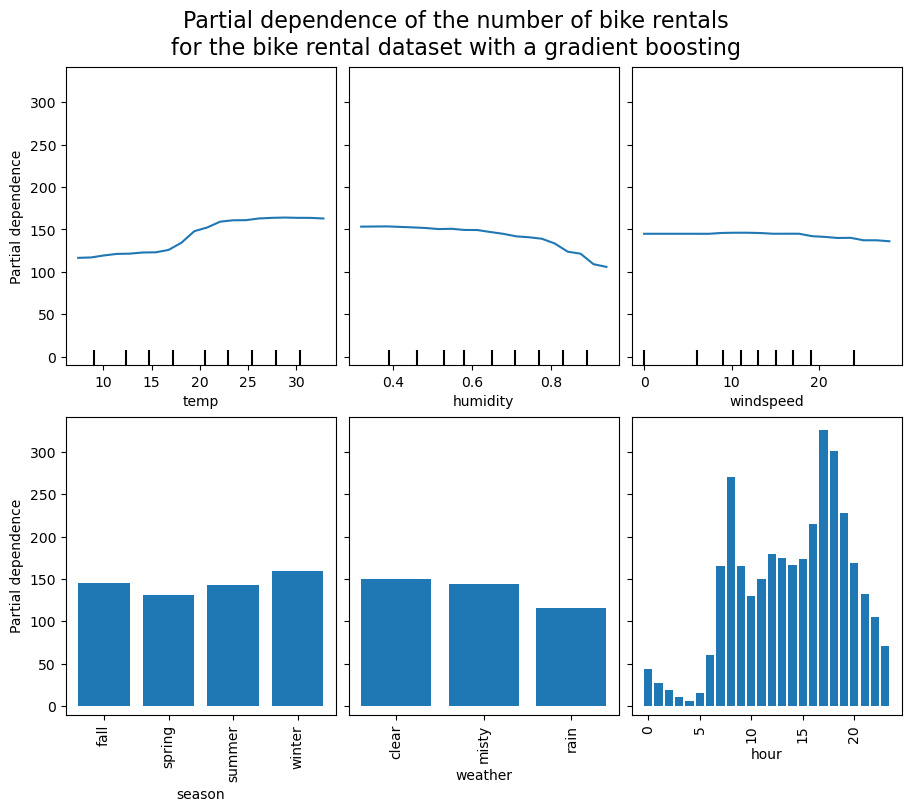

In [31]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of the number of bike rentals\n"
    "for the bike rental dataset with a gradient boosting",
    fontsize=16,
)

Computing partial dependence plots and individual conditional expectation...
done in 1.635s


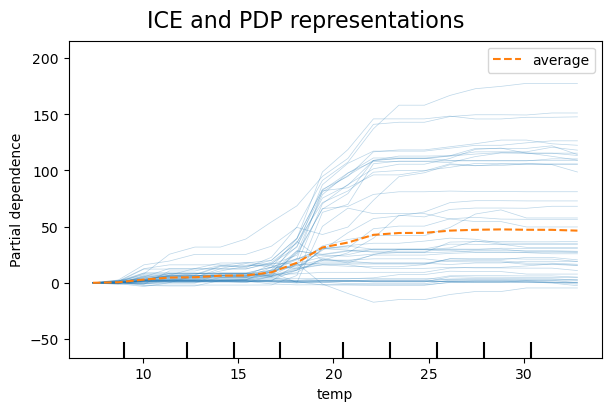

In [32]:
print("Computing partial dependence plots and individual conditional expectation...")
tic = time()
_, ax = plt.subplots(ncols=1, figsize=(6, 4), sharey=True, constrained_layout=True)

features_info = {
    "features": ["temp"],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

In [33]:
def MyPartialDependencePlot(model, X, feature_idx, n_points=100, categorical=False, percentiles=(0.05,0.95), kind="average", target=1, alpha = 0.3, subsample=50):
    
    y = X.iloc[:,feature_idx]
    if categorical == False:
        min_value = np.percentile(y,100*percentiles[0])
        max_value = np.percentile(y,100*percentiles[1])
    #print(min_value)
    #print(max_value)
    if (len(y.unique()) < n_points):
        x_range = np.sort(y.unique())
    else:
        step_size = (max_value-min_value)/n_points
        x_range = range(int(min_value), int(max_value), int(step_size))
        
    range_length = len(x_range)
    avgs = []
    inds = np.zeros((len(y),range_length))
    x = []
    if categorical == False:
        y = y[(y>=min_value) & (y<=max_value)]
    
    x_idx=0
    for i in x_range:
        # set all the column values to i and make predictions. This generates the response of the model for
        # all variations of the other features' values that are in the dataset.
        X.iloc[:,feature_idx] = i
        if (is_classifier(model)):
            preds = model.predict_proba(X)[:,target]
        else:
            preds = model.predict(X)
        avgs.append(np.mean(preds))
        inds[:,x_idx]=preds
        x.append(i)
        x_idx += 1
    if kind=="average" or kind=="both":
        plt.plot(x,avgs)
    if kind=="individual" or kind=="both":
        ice_lines_idx = random.sample(
            range(inds.shape[0]),
            subsample
        )
        for i in ice_lines_idx:
            plt.plot(x,inds[i],color="k",linewidth=0.5, alpha=alpha)
    ax = plt.gca()
    diff = max(avgs) - min(avgs)
    if categorical == False:
        deciles = np.percentile(y, np.arange(0, 100, 10))
        ax.vlines(deciles, min(avgs), min(avgs)+diff*0.05,color="k")
    #plt.ylim(min(avgs), max(avgs))
    plt.xlabel(X.columns[feature_idx])


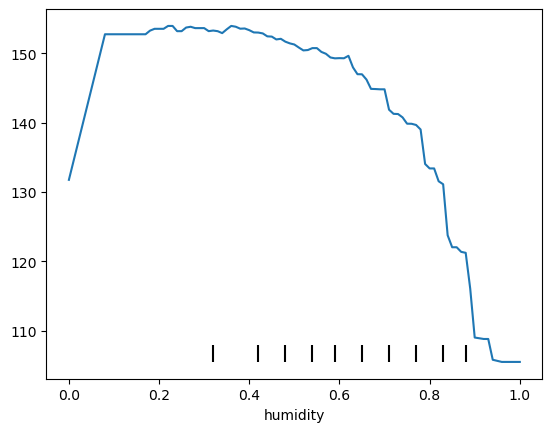

In [34]:
A = X_train.copy()
MyPartialDependencePlot(hgbdt_model, A, 9, 100, kind="average")

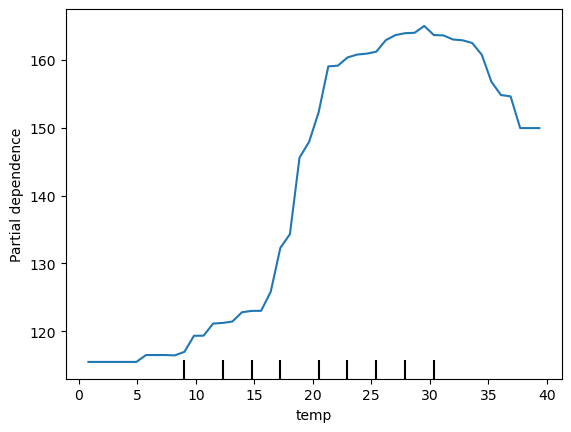

In [35]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[7], kind='average');

TypeError: cannot unpack non-iterable NoneType object

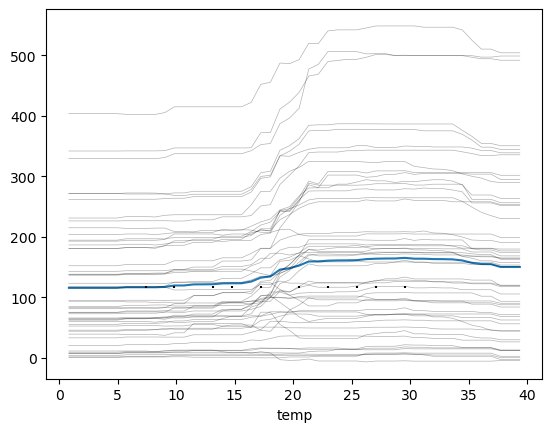

In [36]:
A = X_train.copy()
x, inds = MyPartialDependencePlot(hgbdt_model, A, 7, 100, kind="both")

In [ ]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[7], subsample= 50,centered=False,kind='both', random_state=0);

In [ ]:
PartialDependenceDisplay.from_estimator(hgbdt_model,X_train,[0], categorical_features=[0]);

In [ ]:
MyPartialDependencePlot(hgbdt_model,X_train,0, categorical=True);

In [ ]:
X.head(5)

In [ ]:
PartialDependenceDisplay.from_estimator(clf,X_train,[0], target=1);

In [ ]:
A = X_train.copy()
MyPartialDependencePlot(clf, A, 0, kind="average")

### Shapley Values

Suppose thay we have three players: A, B, and C. They will play a cooperative game and will obtain a certain gain. Players' individual contribution might be different. We want to calculate the marginal conributions of each player in order to distribute the gain according to their marginal contributions. How can we do it?

The basic idea is to find the marginal contribution of a player, say A, according to the gains in games where A is present and where A is not.



Shapley value:

$$
\phi_i(v) = \sum_{\substack{S \subseteq N \backslash \{i\} }} \frac{(n - |S| - 1)! \cdot (|S|)!}{n!} \left( v(S \cup \{i\}) - v(S) \right) 
$$

where:
- $ \phi_i(v) $ represents the Shapley value of player \( i \) in the game \( v \),
- $ N $ is the set of all players,
- $ S $ is a coalition of players,
- $ n $ is the total number of players, and
- $ v(S) $ denotes the worth of coalition $S$.



In [8]:
import math
import itertools

def calculate_shapley_value(player, player_list, characteristic_function):
    n = len(player_list)
    shapley_value = 0

    for permutation in itertools.permutations(player_list):
        print("Order:", permutation)
        coalition = []
        coalition_value = 0

        for p in permutation:
            if p == player:
                break
            else:
                coalition.append(p)
                
        coalition_value = characteristic_function(coalition)
        coalition.append(player)
        coalition_value_with_player = characteristic_function(coalition)

        marginal_contribution = coalition_value_with_player - coalition_value
        print("Marginal contribution of ", player, ": ",marginal_contribution)
        shapley_value += marginal_contribution / math.factorial(n)

    return shapley_value

# Example characteristic function
def characteristic_function(coalition):
    # Define the characteristic function here
    if len(coalition) == 0:
        return 0
    elif len(coalition) == 1:
        player = coalition[0]
        if player == 'A':
            return 100
        elif player == 'B':
            return 125
        elif player == 'C':
            return 50
    elif len(coalition) == 2:
        if 'A' in coalition and 'B' in coalition:
            return 270
        elif 'A' in coalition and 'C' in coalition:
            return 375
        elif 'B' in coalition and 'C' in coalition:
            return 350
    elif len(coalition) == 3:
        return 500

# Player list
player_list = ['A', 'B', 'C']

# Calculate Shapley values for each player
shapley_values = {}
for player in player_list:
    shapley_values[player] = calculate_shapley_value(player, player_list, characteristic_function)

# Print the Shapley values
for player, value in shapley_values.items():
    print(f"The Shapley value for player {player} is: {value}")


Order: ('A', 'B', 'C')
Marginal contribution of  A :  100
Order: ('A', 'C', 'B')
Marginal contribution of  A :  100
Order: ('B', 'A', 'C')
Marginal contribution of  A :  145
Order: ('B', 'C', 'A')
Marginal contribution of  A :  150
Order: ('C', 'A', 'B')
Marginal contribution of  A :  325
Order: ('C', 'B', 'A')
Marginal contribution of  A :  150
Order: ('A', 'B', 'C')
Marginal contribution of  B :  170
Order: ('A', 'C', 'B')
Marginal contribution of  B :  125
Order: ('B', 'A', 'C')
Marginal contribution of  B :  125
Order: ('B', 'C', 'A')
Marginal contribution of  B :  125
Order: ('C', 'A', 'B')
Marginal contribution of  B :  125
Order: ('C', 'B', 'A')
Marginal contribution of  B :  300
Order: ('A', 'B', 'C')
Marginal contribution of  C :  230
Order: ('A', 'C', 'B')
Marginal contribution of  C :  275
Order: ('B', 'A', 'C')
Marginal contribution of  C :  230
Order: ('B', 'C', 'A')
Marginal contribution of  C :  225
Order: ('C', 'A', 'B')
Marginal contribution of  C :  50
Order: ('C', 'B

### Global, cohort, and local model explainability.

### Shapley value calculation from scratch with sampling

The following code makes a local explanation. The algorithm is as follows:

To calculate the Shapley value for the feature $f_j$ in the prediction for instance $i$:

- for m = 1 to M do:
    - Sample a random subset of features $S_f$ such that $f_j \not\in S_f$.
    - Calculate the marginal contribution of $f_j$ by finding the difference between the prediction with features $S_f + f_j$ and features $S_f$.
    
The average marginal contribution will give the shapely value. This is not exact calculation but will approximate it. One problem is how to make a prediction with only a subset of the features since the model is built with all the features. Building different models for all feature subsets is infeasible. One solution is to use values for the missing features from a randomly choosen instance. The idea is when we do this many times the overall effect of the randomly chosen values will cancel out and in the long run the contribution of $f_j$ for the instance $x$ will emerge.



In [30]:
np.random.randint(10)

9

In [292]:
feature_idxs = list(range(n_features))
feature_idxs.remove(7)
S_f = np.random.choice(feature_idxs, np.random.randint(n_features-1))
S_f

array([ 2, 12, 13,  1, 13,  2])

In [85]:
feature_idxs.remove(9)

In [64]:
X.sample(1).values[0][fs]

array([  0.,   3.,  11.,   3.,  27., 533.,  11.,  27.])

In [72]:
x_with_feature = np.array([x[i] if i in S_f + [7] else r[i] for i in range(n_features)])
x_with_feature.reshape(1, -1)

array([[  6.,   3., 649.,  14.,   8.,   3.,   7.,   2.,   4.,   0.,   0.,
          0.,  28.,  27.]])

In [9]:
def shapley_value_by_sampling(model, X, instance_idx, feature_idx, n_iters = 1000):
    
    marginal_contributions = []

    n_features = X.shape[1]
    feature_idxs = list(range(n_features))
    x = X.iloc[instance_idx]
    feature_idxs.remove(feature_idx)

    for _ in range(n_iters):
        r = X.sample(1).values[0]

        # sample S_f
        S_f = random.sample(feature_idxs, random.randint(0,n_features-1))

        x_with_feature = np.array([x[i] if i in S_f + [feature_idx] else r[i] for i in range(n_features)])
        x_without_feature = np.array([x[i] if i in S_f else r[i] for i in range(n_features)])
    
        marginal_contribution = model.predict_proba(x_with_feature.reshape(1, -1))[0][1] - model.predict_proba(x_without_feature.reshape(1, -1))[0][1]
        marginal_contributions.append(marginal_contribution)
        
    shapley_value = sum(marginal_contributions) / len(marginal_contributions)  
    return X.columns[feature_idx], shapley_value


In [10]:
shapley_value_by_sampling(model, X, 10, 7)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

('relationship', -0.1314809643651754)

In [298]:
random.randint(0,10)

9

In [57]:
np.array([x[i] if i in x_idx + [j] else z[i] for i in range(n_features)])

array([  6.,   6., 927.,  11.,   7.,   3.,   4.,   0.,   4.,   1.,   0.,
         0.,  15.,  27.])

In [58]:
np.array([x[i] if i in x_idx else z[i] for i in range(n_features)])

array([  6.,   6., 927.,  11.,   7.,   3.,   4.,   3.,   4.,   1.,   0.,
         0.,  15.,  27.])

In [13]:
explainer = shap.explainers.Exact(model.predict_proba, X)
shap_values = explainer(X[:10])
# get just the explanations for the positive class
shap_values = shap_values[...,1]

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

### Global Explanations

In [12]:
shap.plots.bar(shap_values);

NameError: name 'shap_values' is not defined

### Local Explanations

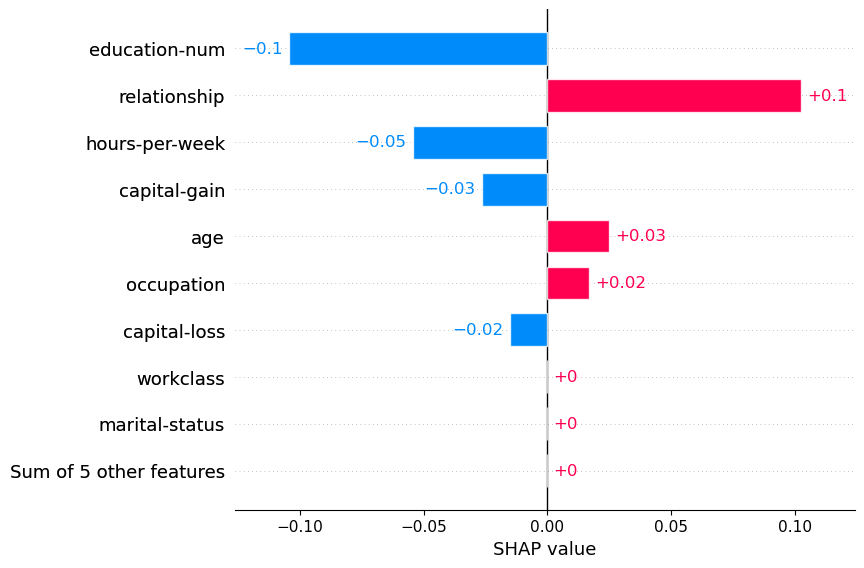

In [304]:
shap.plots.bar(shap_values[10]);

In [70]:
shap_values[2]

.values =
array([ 6.77083333e-03, -1.08420217e-18,  1.27935856e-17,  1.62630326e-17,
        2.63512366e-01, -7.13982530e-03,  2.62059109e-02,  3.17306316e-01,
        1.08420217e-18, -2.38524478e-18, -1.27234519e-02, -4.03614458e-03,
        4.50227297e-03,  0.00000000e+00])

.base_values =
0.2195552117816949

.data =
array([ 25.,   2., 694.,   9.,  11.,   2.,   3.,   0.,   4.,   1.,   0.,
         4.,  28.,  29.])

In [67]:
model.predict_proba(X[:10])

array([[0.98847262, 0.01152738],
       [1.        , 0.        ],
       [0.18604651, 0.81395349],
       [0.98847262, 0.01152738],
       [0.89922481, 0.10077519],
       [0.89922481, 0.10077519],
       [0.89922481, 0.10077519],
       [0.98847262, 0.01152738],
       [0.80722892, 0.19277108],
       [0.98847262, 0.01152738]])

In [74]:
sum(shap_values[8].values) + shap_values[8].base_values

0.192771084337353

In [85]:
np.mean(model.predict_proba(X[:100])[:,1])

0.2768755364667598

How does the base_value is calculated? and why shapley values + the base_value equals 
the predicted value.

In [86]:
explainer = shap.explainers.Permutation(model.predict_proba, X)
shap_values = explainer(X[:100])
# get just the explanations for the positive class
shap_values = shap_values[...,1]

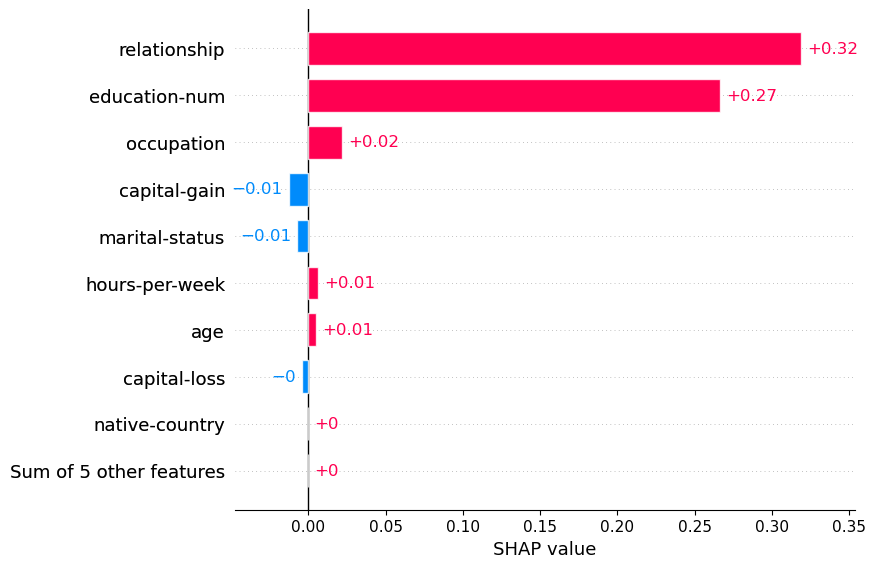

In [87]:
shap.plots.bar(shap_values[2]);

In [92]:
shap_values[2]

.values =
array([ 0.00514706,  0.        ,  0.        ,  0.        ,  0.26627846,
       -0.00713983,  0.02204412,  0.31886556,  0.        ,  0.        ,
       -0.01272345, -0.00403614,  0.00596249,  0.        ])

.base_values =
0.2195552117816949

.data =
array([ 25.,   2., 694.,   9.,  11.,   2.,   3.,   0.,   4.,   1.,   0.,
         4.,  28.,  29.])

-0.24000000000000005

In [7]:
explainer = shap.KernelExplainer(model.predict_proba, X)
shap_values1 = explainer.shap_values(X[10:11])
shap_values1

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

[array([[ 0.        ,  0.00387254, -0.00245719,  0.01255536,  0.04993876,
          0.02006729,  0.01904725,  0.06949221,  0.00480957, -0.00145887,
          0.04245589,  0.00857998,  0.0347626 ,  0.0033346 ]]),
 array([[ 0.        , -0.00387254,  0.00245719, -0.01255536, -0.04993876,
         -0.02006729, -0.01904725, -0.06949221, -0.00480957,  0.00145887,
         -0.04245589, -0.00857998, -0.0347626 , -0.0033346 ]])]

In [8]:
explainer = shap.TreeExplainer(model, X)
shap_values1 = explainer.shap_values(X[10:11])
shap_values1

[array([[-0.00333333, -0.00057143, -0.0005    ,  0.00683333,  0.048     ,
          0.0215    ,  0.02083333,  0.06033333, -0.00033333,  0.        ,
          0.02790476,  0.00866667,  0.0495    ,  0.00116667]]),
 array([[ 0.00333333,  0.00057143,  0.0005    , -0.00683333, -0.048     ,
         -0.0215    , -0.02083333, -0.06033333,  0.00033333,  0.        ,
         -0.02790476, -0.00866667, -0.0495    , -0.00116667]])]

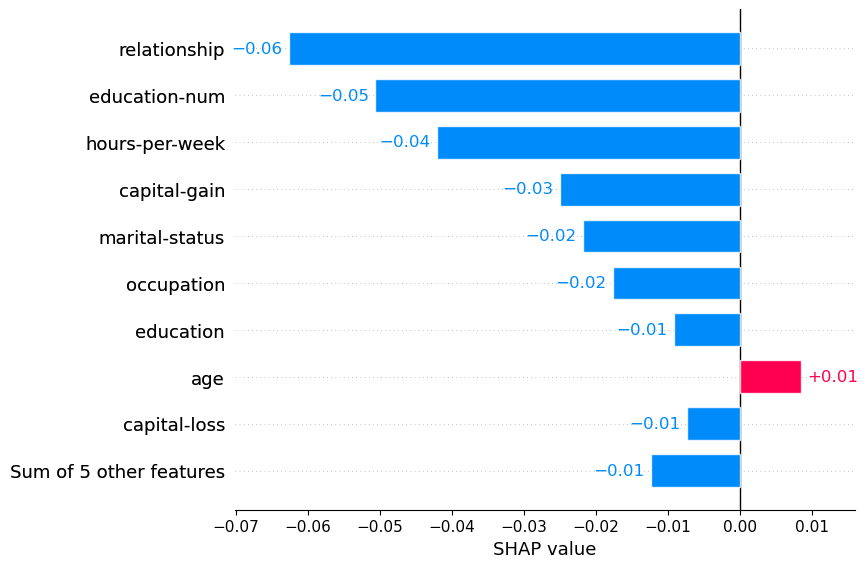

In [13]:
shap_values[0]

.values =
array([[ 0.00441176, -0.00441176],
       [-0.00088235,  0.00088235],
       [-0.00735294,  0.00735294],
       [ 0.00882353, -0.00882353],
       [ 0.04294118, -0.04294118],
       [ 0.03205882, -0.03205882],
       [ 0.01323529, -0.01323529],
       [ 0.06088235, -0.06088235],
       [-0.00558824,  0.00558824],
       [ 0.        ,  0.        ],
       [ 0.02764706, -0.02764706],
       [ 0.00764706, -0.00764706],
       [ 0.05529412, -0.05529412],
       [ 0.00088235, -0.00088235]])

.base_values =
array([0.76, 0.24])

.data =
array([ 39.,   3., 912.,   5.,   2.,   4.,   4.,   4.,   2.,   0.,   0.,
         0.,  14.,  29.])

In [154]:
# train XGBoost model
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 99%|===================| 32371/32561 [01:20<00:00]        

In [157]:
shap_values[0]

.values =
array([ 0.62066666, -0.4340129 ,  0.40111691, -0.41627076, -0.11005208,
       -0.46145511,  0.03216866,  0.33387261, -2.97870277, -0.11033077,
       -0.09677085,  0.01754525])

.base_values =
-2.6846917539397146

.data =
array([3.900e+01, 7.000e+00, 1.300e+01, 4.000e+00, 1.000e+00, 0.000e+00,
       4.000e+00, 1.000e+00, 2.174e+03, 0.000e+00, 4.000e+01, 3.900e+01])

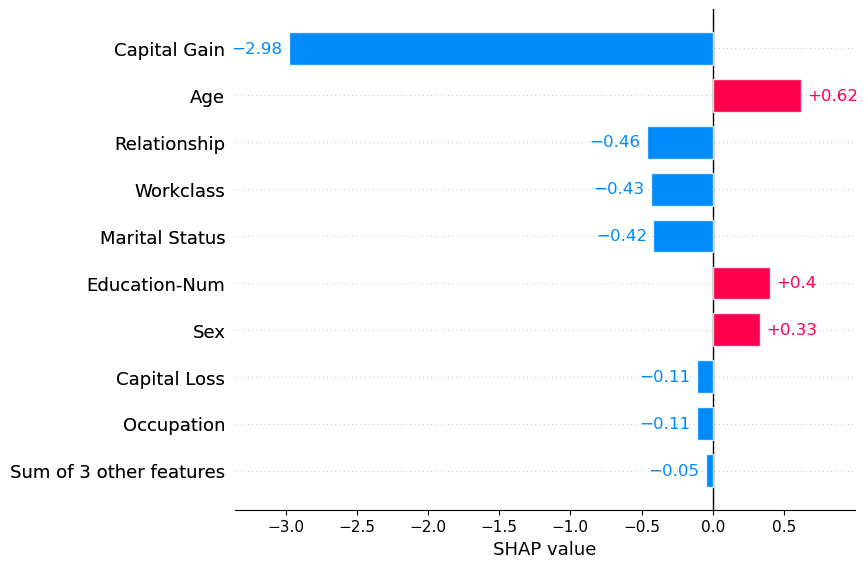

In [158]:
shap.plots.bar(shap_values[0]);

In [134]:
a.shape

(14, 2)

In [125]:
shap_values[0]

.values =
array([[-0.01176471,  0.01176471],
       [-0.00558824,  0.00558824],
       [ 0.06558824, -0.06558824],
       [ 0.00323529, -0.00323529],
       [-0.21147059,  0.21147059],
       [ 0.        ,  0.        ],
       [-0.01764706,  0.01764706],
       [-0.29294118,  0.29294118],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.02411765, -0.02411765],
       [ 0.        ,  0.        ],
       [-0.32294118,  0.32294118],
       [-0.00058824,  0.00058824]])

.base_values =
array([0.77, 0.23])

.data =
array([ 18.,   3., 854.,   7.,  11.,   1.,   3.,   0.,   4.,   1.,   0.,
         0.,  51.,  27.])

In [128]:
shap_values[...,1]

.values =
array([[ 0.01176471,  0.00558824, -0.06558824, -0.00323529,  0.21147059,
         0.        ,  0.01764706,  0.29294118,  0.        ,  0.        ,
        -0.02411765,  0.        ,  0.32294118,  0.00058824]])

.base_values =
array([0.23])

.data =
array([[ 18.,   3., 854.,   7.,  11.,   1.,   3.,   0.,   4.,   1.,   0.,
          0.,  51.,  27.]])

In [73]:
shap_values[:,1]

.values =
array([[-0.00558824,  0.00558824]])

.base_values =
array([[0.77, 0.23]])

.data =
array([3.])

In [88]:
shap_values[...,1]

.values =
array([[ 0.01176471,  0.00558824, -0.06558824, -0.00323529,  0.21147059,
         0.        ,  0.01764706,  0.29294118,  0.        ,  0.        ,
        -0.02411765,  0.        ,  0.32294118,  0.00058824]])

.base_values =
array([0.23])

.data =
array([[ 18.,   3., 854.,   7.,  11.,   1.,   3.,   0.,   4.,   1.,   0.,
          0.,  51.,  27.]])

In [117]:
from slicer import Slicer as S
from slicer import Alias as A

data = [[1, 2], [3, 4]]
values = [[5, 6], [7, 8]]
identifiers = ["id1", "id1"]
instance_names = ["r1", "r2"]
feature_names = ["f1", "f2"]
full_name = "A"


slicer = S(
    data=data,
    values=values,
    # Aliases are objects that also function as slicing keys.
    # A(obj, dim) where dim informs what dimension it can be sliced on.
    full_name=full_name,
)



In [120]:
slicer

Slicer({'o': [], 'data': [[1, 2], [3, 4]], 'values': [[5, 6], [7, 8]], 'full_name': 'A'})

X has feature names, but DecisionTreeClassifier was fitted without feature names


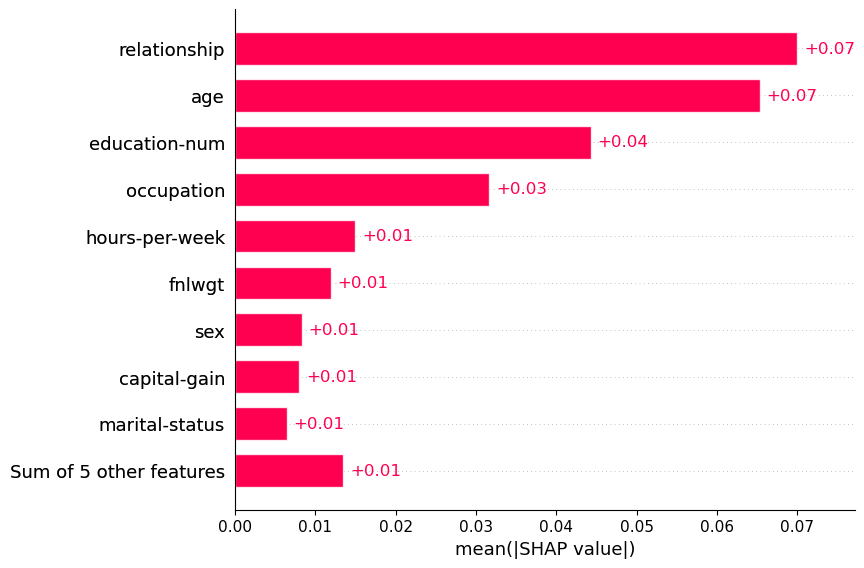

In [71]:
#X,y = shap.datasets.adult()
#model = DecisionTreeClassifier().fit(X, y)

explainer = shap.explainers.Exact(model.predict_proba, X)
shap_values = explainer(X[10:11])
shap.plots.bar(shap_values[...,1])

In [53]:
shap_values

.values =
array([[[ 8.39047619e-02, -8.39047619e-02],
        [ 2.90476190e-03, -2.90476190e-03],
        [ 3.37380952e-02, -3.37380952e-02],
        [ 3.00000000e-03, -3.00000000e-03],
        [-6.74285714e-02,  6.74285714e-02],
        [-7.00000000e-03,  7.00000000e-03],
        [-1.59523810e-03,  1.59523810e-03],
        [ 1.28571429e-01, -1.28571429e-01],
        [ 7.80625564e-18,  2.38524478e-18],
        [ 2.38333333e-02, -2.38333333e-02],
        [ 8.50000000e-03, -8.50000000e-03],
        [ 3.33333333e-03, -3.33333333e-03],
        [ 2.99047619e-02, -2.99047619e-02],
        [-1.66666667e-03,  1.66666667e-03]]])

.base_values =
array([[0.76, 0.24]])

.data =
array([[  7.,   3., 336.,   9.,  12.,   3.,   1.,   1.,   4.,   0.,   0.,
          0.,  23.,  28.]])

In [43]:
explainer = shap.KernelExplainer(model.predict_proba, X)
shap_values = explainer.shap_values(X.iloc[5,:])
print(f"Shaply value calulated from shap: {shap_values[1][j]:.5}")


.values =
array([[ 0.00321061, -0.00035447,  0.06162489, ..., -0.01513889,
         0.00422168, -0.00071825],
       [ 0.02841349,  0.0116127 ,  0.04444921, ..., -0.0264585 ,
        -0.27815516,  0.0027123 ],
       [-0.00302583, -0.0431832 , -0.02861611, ..., -0.01933175,
        -0.01121996, -0.00192526],
       ...,
       [ 0.11739177,  0.05934256,  0.10560774, ..., -0.00336032,
         0.2551621 ,  0.00134127],
       [ 0.06406219,  0.00666905,  0.01129354, ..., -0.00852222,
         0.0058197 ,  0.02902529],
       [-0.03889123,  0.0176056 , -0.02752012, ..., -0.02198441,
        -0.01415043, -0.00080357]])

.base_values =
array([0.23083333, 0.23083333, 0.23083333, 0.23083333, 0.23083333,
       0.23083333, 0.23083333, 0.23083333, 0.23083333, 0.23083333,
       0.23083333, 0.23083333, 0.23083333, 0.23083333, 0.23083333,
       0.23083333, 0.23083333, 0.23083333, 0.23083333, 0.23083333,
       0.23083333, 0.23083333, 0.23083333, 0.23083333, 0.23083333,
       0.23083333, 0.23083

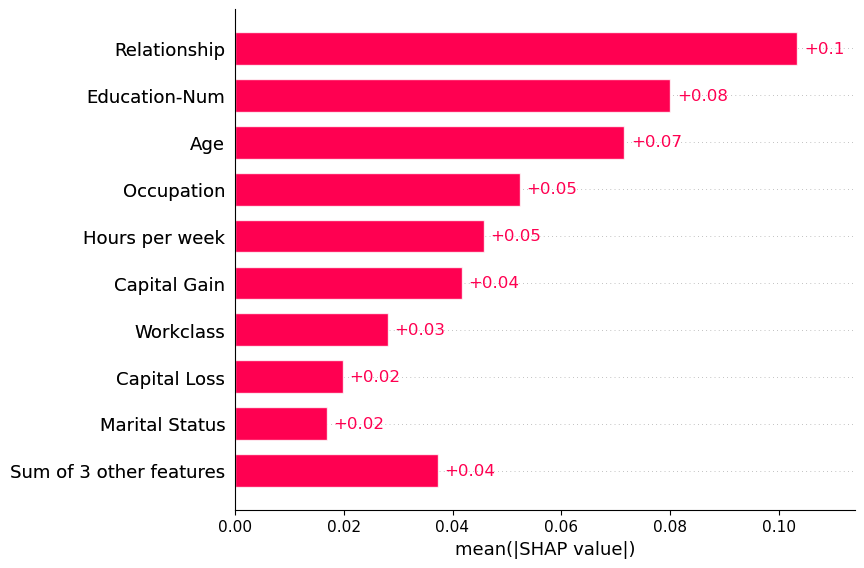

In [36]:
shap.plots.bar(shap_values)

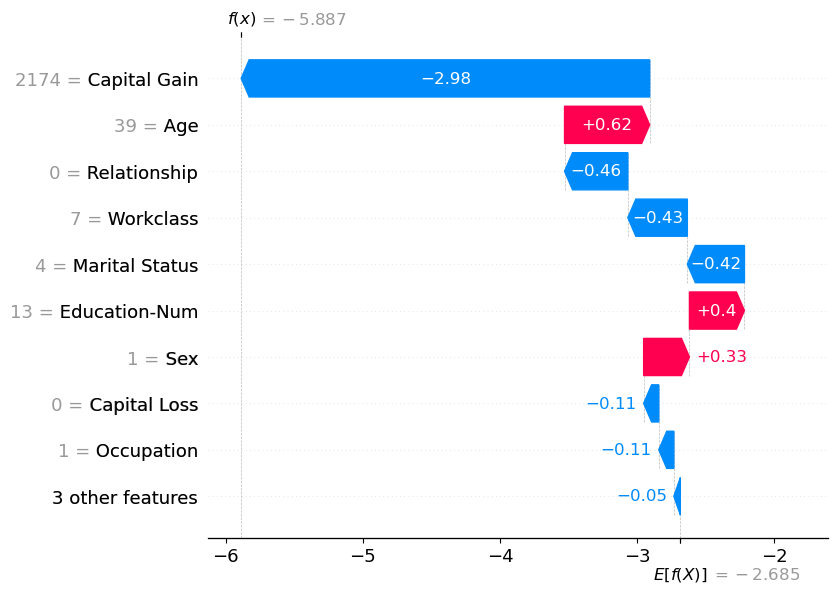

In [27]:
X,y = shap.datasets.adult()
model = DecisionTreeClassifier().fit(X, y)

# compute SHAP values
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
X,y = shap.datasets.adult()
model = DecisionTreeClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model.predict_proba, X)
shap_values = explainer(X)

In [5]:


# train XGBoost model
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

100%|===================| 32427/32561 [01:21<00:00]        

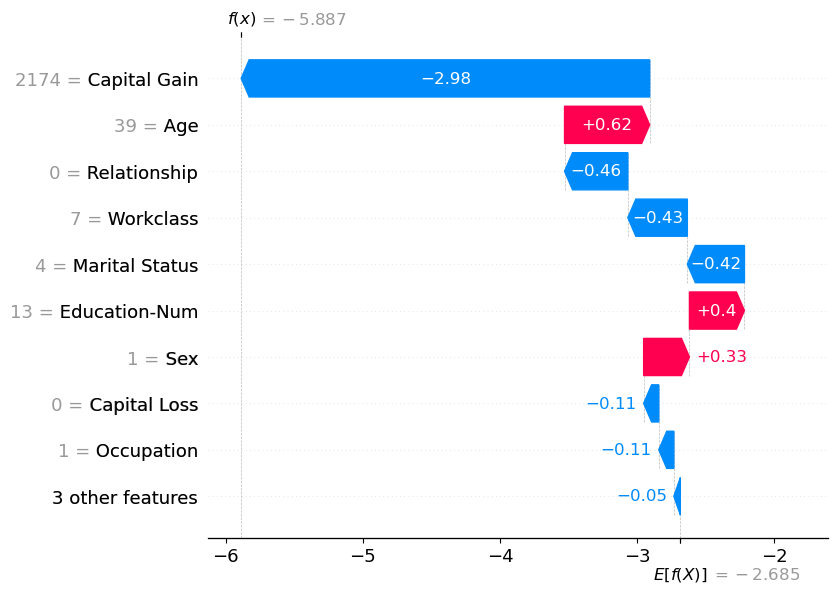

In [6]:
shap.plots.waterfall(shap_values[0])

In [ ]:

# explain the model's predictions using SHAP
explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.iloc[sample_idx,:])

In [ ]:
print(f"Shaply value calulated from shap: {shap_values[1][j]:.5}")

In [ ]:
shap_values